# Imports and processes firn cores from SUMUP (2024) dataset and a standardized dataset compiled by Peter Kuipers Munneke

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import matplotlib.pyplot as plt
import xarray as xr

from scipy.optimize import curve_fit
from scipy.optimize import fsolve, brentq

from merge_datasets import *
from process_standardized_cores import *
from process_sumup_cores import *



### 1. Processing SUMup data

First, load all the data from the region of interest (Antarctica or Greenland). Set the paths appropriately so that it links to your own folder with sumup data.

In [3]:
# process sumup cores

data_path = "/home/nld4814/perm/cores/sumup/source"  # Update this to your SUMup data folder
output_path = "/home/nld4814/perm/cores/sumup/processed/"  # Path to save output files (can be same as data_path)
output_prefix = "sumup_550_830_density_depths"  # Will create _greenland.csv, _antarctica.csv, and _combined.csv files
domain = "greenland"

density_df, profile_names_df, references_df = load_sumup_data(data_path, domain)


Loading SUMup data files...
Loading Greenland data only
Loaded 1,976,302 greenland density measurements
Loaded 4229 profile names
Loaded 271 references


We can select cores from the density dataset `density_df` by profile_key -- this gives us all the measurements of depth and density; the other information is identical. We can then plot it, and use the core's name for it's title by searching for the `profile_key` in the `profile_names_df` dataframe.

Text(0.5, 0, 'Density [kg/m3]')

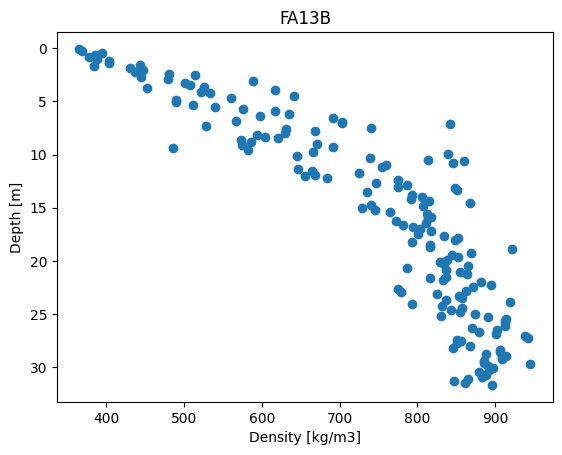

In [ ]:
prof57 = density_df[density_df["profile_key"]==57]
plt.plot(prof57["density"],prof57["midpoint"], 'o')
plt.title(profile_names_df.loc[57]["profile"])
plt.gca().invert_yaxis()
plt.ylabel("Depth [m]")
plt.xlabel("Density [kg/m3]")

There are a few ways of going about choosing depth to 550 kg/m3 and 830 kg/m3. We are going to take the easiest option: look for the first instance where the depth exceeds the target density, and we interpolate between that point and the point previous to get the depth. We could also fit a curve to the depth-density profile, and then select a depth from there. We cannot just use a built in funciton like `interp_1d` because the densities often do not monotonically increase with depth

In [ ]:
# let's simplify the structure of our dataframe so we can find the depths of the target densities more easily

prof57 = density_df[density_df["profile_key"]==57]
prof57 = prof57.drop(columns=['reference_key', 'method_key', 'start_depth', 'stop_depth', 'error', 'region'])
prof57 = prof57.rename(columns={"midpoint": "depth"})
prof57.head()

,profile_key,timestamp,latitude,longitude,elevation,depth,density
0,57,2013-04-08,66.1812,-39.043499,1563.0,0.220,368.42
1,57,2013-04-08,66.1812,-39.043499,1563.0,1.175,402.91
2,57,2013-04-08,66.1812,-39.043499,1563.0,14.710,740.07
3,57,2013-04-08,66.1812,-39.043499,1563.0,0.425,394.59
4,57,2013-04-08,66.1812,-39.043499,1563.0,0.630,385.00


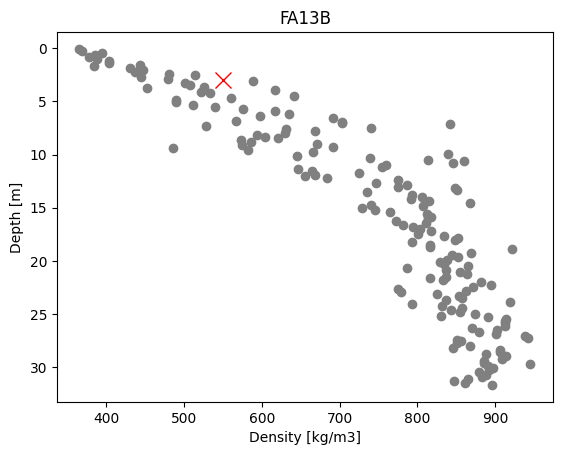

In [ ]:
# an example for a target density of 550
df = prof57.copy()
failed = False

target_density = 550

depth = np.array(df.depth.values)
density = np.array(df.density.values)

# Sort by depth - should monotonically increase (but density likely won't)
sort_idx = np.argsort(depth)
depth_sorted = depth[sort_idx]
density_sorted = density[sort_idx]

# Check if target density is reached
if np.max(density_sorted) < target_density:
    print("Core too shallow, do not proceed")
    failed = True
    #return np.nan

if not failed:
    # Find first point where target density is reached or exceeded
    idx = np.where(density_sorted >= target_density)[0]

    first_idx = idx[0]
    
    # If first measurement already exceeds target, interpolate previous depth is zero. we choose 350 to be the density at the surface.
    if first_idx == 0:
        prev_depth = 0
        prev_density = 350
    else:
        prev_depth = depth_sorted[first_idx - 1]
        prev_density = density_sorted[first_idx - 1]
    
    curr_depth = depth_sorted[first_idx]
    curr_density = density_sorted[first_idx]
        
    # Weighted interpolatation based on distance and density difference
    interpolated_depth = prev_depth + (target_density - prev_density) * (curr_depth - prev_depth) / (curr_density - prev_density)

    interpolated_depth = round(interpolated_depth,2)

    #now let's plot it and make sure it looks reasonable

    plt.plot(df["density"],df["depth"], 'o', color="grey")
    plt.plot(550, interpolated_depth, 'rx', markersize=12, label='Interpolated Depth at 550 kg/m3')
    plt.gca().invert_yaxis()
    plt.ylabel("Depth [m]")
    plt.xlabel("Density [kg/m3]")

    plt.title(profile_names_df.loc[57]["profile"])



We could also choose to fit a curve to the data and then select a density from there. In general, a logarithmic or power law fit does well with depth-density datasets.

First we define the fits we could use, and the minimization of that fit with a target (for finding the depth at target density later on)

In [ ]:
def power_law(x, a, b, c):
    return a * x**b + c

def power_law_minimization(x, a, b, c, target):
    return a * x**b + c - target

def logarithmic(x, a, b, c):
    return a * np.log(x + 1) + b * x + c

def log_minimization(x, a, b, c, target):
    return a * np.log(x + 1) + b * x + c - target

models = [
    (power_law, "Power law", "a*x^b + c", 'blue'),
    (logarithmic, "Logarithmic", "a*log(x+1) + b*x + c", 'green')
]

Then we fit the models to the data. Let's start with the logarithmic curve

In [ ]:
model = models[1]
func = model[0]
color = model[3]

fitted_params = {}

depth_smooth = np.linspace(depth.min(), depth.max(), 200)

popt, pcov = curve_fit(func, depth, density)

# Store parameters with a simple key
model_name = "logarithmic"
fitted_params[model_name] = popt

# Calculate fitted values
density_smooth = func(depth_smooth, *popt)


Now we can find the density at the target depth using the fit we just calculated

In [ ]:
try:
    depth_at_rho = brentq(
        log_minimization,
        depth.min(),
        depth.max(),
        args=(*popt, target_density)
    )
    #print(f"Using brentq (Logarithmic): {depth_at_rho:.2f}")
except ValueError as e:
    #print(f"brentq failed for logarithmic: {e}")
    #print("Target density might be outside the range of your data")
    depth_at_rho = np.nan
    failed = int(1)



And plot them

Text(0.5, 1.0, 'FA13B')

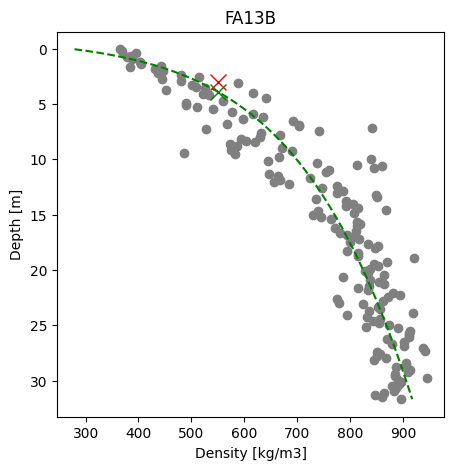

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(density, depth, 'o', color='grey', label='Core Observations')
ax.plot(density_smooth, depth_smooth, '--', color=color, label=f'Fitted {model[1]}')
ax.plot(target_density, depth_at_rho, 'gx', markersize=12, label='Model fit')
plt.plot(550, interpolated_depth, 'rx', markersize=12, label='Point interpolation')
plt.gca().invert_yaxis()
plt.ylabel("Depth [m]")
plt.xlabel("Density [kg/m3]")

plt.title(profile_names_df.loc[57]["profile"])


In [ ]:
#In processing the SUMup dataset, we choose to try to do a logarithmic fit; if that fit fails or if the r2 of that fit is <0.9, then we do the first index approach.

process_sumup_main()

Loading SUMup data files...
Loading Greenland data only
Loaded 1,976,302 greenland density measurements
Loaded 4229 profile names
Loaded 271 references
Processing individual cores...
  - Model fit failed for target density 550 kg/m³
  - Using direct interpolation method instead.
Error: Axes.set() got an unexpected keyword argument 'figsize'

Make sure you have downloaded the SUMup data files.

    To use this script, you need to download the SUMup 2023 dataset:
    
    1. Go to: https://arcticdata.io/catalog/view/doi:10.18739/A2M61BR5M
    2. Download the following CSV files:
       - SUMup_2024_density_csv.zip
            - SUMup_2024_density_greenland.csv
            - SUMup_2024_density_antarctica.csv
            - SUMup_2024_density_profile_names.tsv
            - SUMup_2024_density_references.tsv
    
    3. Place them in a folder and update the 'data_path' variable below.
    


<Figure size 800x700 with 0 Axes>

In [ ]:
# check sumup processed
sumup_df = pd.read_csv("/home/nld4814/perm/cores/sumup/data/processed/sumup_550_830_density_depths_greenland.csv")

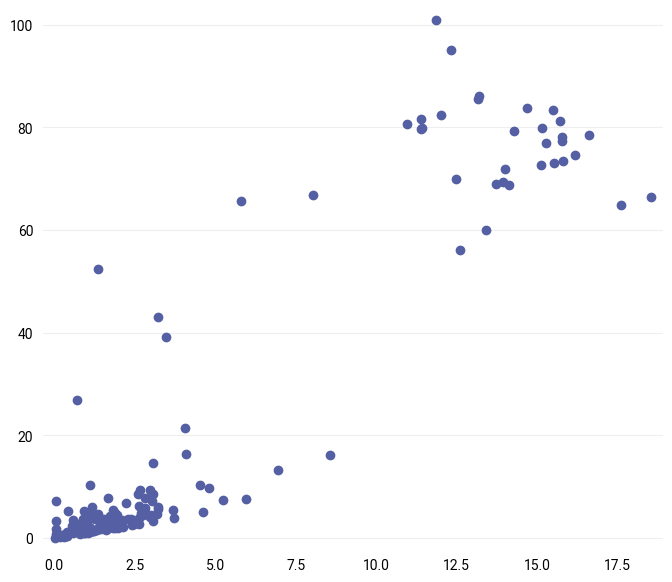

In [ ]:
plt.plot(sumup_df["depth_to_550"], sumup_df["depth_to_830"],'o')

## Process standardized/PKM cores

In [185]:

%autoreload 2
from process_standardized_cores import *

In [186]:
data_dir = "../data/PKM/"
output_dir = "../data/PKM/processed/"
domain='greenland'

metadata_file = data_dir+"cleaned-std-metadata.csv"
text_files_pattern = data_dir+"source/*.txt"  # or "*.std.txt" or "/path/to/cores/*.txt"
output_file = f"{data_dir}processed/PKM_550_830_density_depths_{domain}.csv"

print(f"\nProcessing text files matching pattern: {text_files_pattern}")

text_files = glob.glob(text_files_pattern)
print(f"Found {len(text_files)} text files")

metadata_df = load_std_metadata(metadata_file)
metadata_df.head()


Processing text files matching pattern: ../data/PKM/source/*.txt
Found 67 text files
Loading metadata from ../data/PKM/cleaned-std-metadata.csv


,Name,Longitude,Latitude,Elevation,Year,depth,Method,Citation,Unnamed: 9
0,NASA-U-1,-49.498,73.842,2369.0,1995,150.755,ice core section,Zoek in Kuipers Munneke et al. (2015),NaN
1,NASA-U-2,-49.498,73.842,2369.0,1995,NaN,NaN,checked against denstiy data for PARCA cores 2013,NaN
2,NASA-U-3,-49.498,73.842,2369.0,1995,NaN,NaN,checked against denstiy data for PARCA cores 2013,NaN
3,GITS-Core1,-61.095,77.000,NaN,1996,NaN,NaN,NaN,NaN
4,GITS-Core2,-61.095,77.000,NaN,1996,NaN,NaN,NaN,NaN


In [ ]:
def calculate_depth_to_density(depth, density, core_name, depth_dependence = True, do_plot=True):
    """Calculate depth where density first reaches target value using interpolation"""

    target_densities = [550, 830]
    colors = ['blue', 'red']
    depths_at_target_densities = [np.nan,np.nan]
    failed = [0,0]
    model_failed = [1,1]
    r2 = np.nan

    models = def_models()

    # Remove NaN values
    valid_mask = ~(np.isnan(depth) | np.isnan(density))

    #If too few points, can't do fit
    if valid_mask.sum() < 10:
        
        failed = [1,1]
        print(" - Too few valid points ("+str(valid_mask.sum())+")")

        return depths_at_target_densities, failed, r2
    
    depth = np.array(depth)
    density = np.array(density)
    
    # Sort by depth
    sort_idx = np.argsort(depth)
    depth_sorted = depth[sort_idx]
    density_sorted = density[sort_idx]
    
    # Check if target density is within the range of measured densities
    min_density = density_sorted.min()
    max_density = density_sorted.max()

    # target density out of range
    for idx, rho_i in enumerate(target_densities):
        if rho_i < min_density or rho_i > max_density:
            failed[idx] = 1
            print("  - Target density out of range (" + str(rho_i) + " not in [" + str(min_density) + ", " + str(max_density) + "])")
        
        if all(failed):
            return depths_at_target_densities, failed, r2

      # Try fit to a logarithmic or power law curve.

    #for idx, (func, name, expression, color, func_min) in enumerate(models):
    func, name, expression, color, func_min = models[1] # only log
    
    #Establishes figure
    if do_plot:
        
        fig,ax = plt.subplots(figsize=(5,5))
        ax.plot(density, depth, 'o', label='Core', color='grey')
        ax.set_title(f'{core_name}')
    
    for idx, rho_i in enumerate(target_densities):

        # if this density is not in the data, skip
        if failed[idx] == 1:
            continue

        # Root finding to get depth at target density
        # If rho_i = 550, fits a curve between density.min and idx[density==600]
        # If rho_i = 830, fits a curve between idx[density==550]+1 and density.max
        try: 
            if depth_dependence:
                if rho_i == 550:
                    fit_mask = density_sorted <= 600  # fit only to densities up to 600
                else:
                    fit_mask = density_sorted >= 550  # fit only to densities above 600
            else:
                fit_mask = np.ones_like(density_sorted, dtype=bool)  # use all data

            # Fit the model
            popt, pcov = curve_fit(func, depth_sorted[fit_mask], density_sorted[fit_mask], maxfev=20000)

            # Calculate fitted values
            depth_smooth = np.linspace(depth_sorted.min(), depth_sorted.max(), 200)
            density_fit = func(depth_sorted, *popt)
            density_smooth = func(depth_smooth, *popt)

            # Calculate R²
            residuals = density_sorted - density_fit
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((density_sorted - np.mean(density_sorted))**2)
            r2 = 1 - (ss_res / ss_tot)

            failed[idx] = 0
            model_failed[idx] = 0

            fit_model = (func, popt, name, expression, round(r2,3), func_min)                
    
        except Exception as e:
            print(f"Model fitting failed for {name}: {e}")
    
        # try to find the depth at target density using the best model
            
        # Root finding to get depth at target density    
        try:
            depth_at_rho = brentq(
                fit_model[5],
                depth_sorted.min(),
                depth_sorted.max(),
                args=(*fit_model[1], rho_i)
            )
            
            depths_at_target_densities[idx] = round(depth_at_rho, 2)

        except Exception as e:
            print(f"  - Root finding failed for best model: {fit_model[2]} for {rho_i}.")
            failed[idx] = 1

            # try linear fit if this is the second attempt at fitting
            if not depth_dependence:

                try:

                    func, name, expression, color, func_min = models[2]
                                # Fit the model
                    popt, pcov = curve_fit(func, depth_sorted[fit_mask], density_sorted[fit_mask], maxfev=20000)

                    # Calculate fitted values
                    depth_smooth = np.linspace(depth_sorted.min(), depth_sorted.max(), 200)
                    density_fit = func(depth_sorted, *popt)
                    density_smooth = func(depth_smooth, *popt)

                    model_failed[idx] = 0

                    try:
                        depth_at_rho = brentq(
                            fit_model[5],
                            depth_sorted.min(),
                            depth_sorted.max(),
                            args=(*fit_model[1], rho_i)
                        )
                        
                        depths_at_target_densities[idx] = round(depth_at_rho, 2)
                        
                    except Exception as e:
                        print(f"  - Root finding failed for linear fit for {rho_i}.")
                        failed[idx] = 1

                    pass
                
                except Exception as e:
                
                    print(f"  - Model fit failed for linear fit for {rho_i}.")
                    failed[idx] = 1

                    continue 
    



        if do_plot & (not failed[idx]):
            
            #if fit hasn't failed, plot it
            if model_failed[idx] == 0:
                ax.plot(density_smooth, depth_smooth, '-', label=f'Model for {rho_i}', color=colors[idx])
            
            ax.plot(rho_i, depth_at_rho, 'x', color=colors[idx], markersize=10)

            ax.legend()
            ax.set_xlabel('Density (kg/m³)')
            ax.set_ylabel('Depth (m)')
            ax.set_xlim([250,950])
            
    
    if do_plot:
        plt.gca().invert_yaxis()
        plt.show()


    return depths_at_target_densities, failed, round(r2, 2)

def import_and_process_std_text_files(text_files, metadata_df, depth_dependence=True, do_plot=False):
    """Process all firn core std text files and calculate depth to 550 and 830"""

    
    processed_cores = []
    
    for file_path in text_files:
        # Extract core name from filename
        filename = os.path.basename(file_path)
        core_name = filename.replace('.std.txt', '').replace('.txt', '')
        
        try:
            # Read the text file
            data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['depth', 'density'])
            
            # Find matching metadata
            metadata_match = metadata_df[metadata_df['Name'].astype(str).str.lower() == core_name.lower()]
            
            if metadata_match.empty:
                # Try numeric match for cases like '6345'
                try:
                    core_num = float(core_name)
                    metadata_match = metadata_df[metadata_df['Name'] == core_num]
                except:
                    pass
            
            if metadata_match.empty:
                print(f"Warning: No metadata found for core {core_name}")
                continue
            
            metadata_row = metadata_match.iloc[0]
            
            # Calculate depth to density horizons
            depths_at_targets, failed, r2 = calculate_depth_to_density(data['depth'], data['density'], str(metadata_row['Name']), depth_dependence=depth_dependence, do_plot=do_plot)
            
            # Create core record
            core_record = {
                'core_name': str(metadata_row['Name']),
                'latitude': metadata_row['Latitude'],
                'longitude': metadata_row['Longitude'],
                'elevation': metadata_row.get('Elevation', np.nan),
                'year': metadata_row.get('Year', np.nan),
                'depth_to_550': depths_at_targets[0],
                'depth_to_830': depths_at_targets[1],
                'r2_550': r2,
                'r2_830': r2,
                'failed_fit_550': failed[0],
                'failed_fit_830': failed[1],
                'source': "PKM standardized cores",
                'method': metadata_row.get('Method', ''),
                'citation': metadata_row.get('Citation', ''),
                'measurement_count': len(data),
                'source_file': filename,
                "region": "Greenland"
            }
            
            processed_cores.append(core_record)
            print(f"Processed {core_name}: {len(data)} measurements, depth_550={depths_at_targets[0]}, depth_830={depths_at_targets[1]}\n")
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    cores_df = pd.DataFrame(processed_cores)

    print(f"\nProcessed {len(cores_df)} cores successfully")
    
    return cores_df


In [198]:
# Step 2: Process text files

text_files = glob.glob(text_files_pattern)
print(f"Found {len(text_files)} text files")

depth_dependence = True
new_cores_df = import_and_process_std_text_files(text_files, metadata_df, depth_dependence, do_plot=False)

Found 67 text files
Processed D1: 94 measurements, depth_550=8.92, depth_830=76.22

Processed D5: 155 measurements, depth_550=11.95, depth_830=72.67

  - Target density out of range (830 not in [363.0, 606.0])
Processed NASA-U-3: 19 measurements, depth_550=13.35, depth_830=nan

Processed H4-1: 34 measurements, depth_550=0.83, depth_830=0.97

  - Target density out of range (830 not in [379.5, 610.6])
Processed North_Dye_3: 22 measurements, depth_550=9.65, depth_830=nan

  - Root finding failed for best model: Logarithmic for 550.
  - Root finding failed for best model: Logarithmic for 830.
Processed H5-1: 31 measurements, depth_550=nan, depth_830=nan

  - Target density out of range (830 not in [365.559, 777.586])
Processed 6348: 16 measurements, depth_550=6.21, depth_830=nan

  - Target density out of range (830 not in [312.306, 648.028])
Processed Basin8: 30 measurements, depth_550=13.34, depth_830=nan

  - Target density out of range (830 not in [312.0, 735.0])
Processed Basin4: 24 

In [200]:
new_cores_df[new_cores_df["core_name"]=='H3-1']

,core_name,latitude,longitude,elevation,year,depth_to_550,depth_to_830,r2_550,r2_830,failed_fit_550,failed_fit_830,source,method,citation,measurement_count,source_file,region
18,H3-1,70.0,-48.499667,1540.0,2008,5.94,NaN,0.51,0.51,0,1,PKM standardized cores,NaN,NaN,49,H3-1.std.txt,Greenland


In [201]:
bad_fits = ['GGU163', 'Basin9', '6938', '7145', 'ACT_1', 'North_Dye_3']
text_files_bad_fits = [f for f in text_files if any(bad in f for bad in bad_fits)]
new_fits_for_bad_fits = import_and_process_std_text_files(text_files_bad_fits, metadata_df, depth_dependence=False, do_plot=False)

  - Target density out of range (830 not in [379.5, 610.6])
Processed North_Dye_3: 22 measurements, depth_550=9.64, depth_830=nan

  - Target density out of range (830 not in [366.684, 680.206])
Processed Basin9: 27 measurements, depth_550=12.74, depth_830=nan

  - Target density out of range (830 not in [312.1, 554.8])
  - Root finding failed for best model: Logarithmic for 550.
  - Root finding failed for linear fit for 550.
Processed 6938: 14 measurements, depth_550=nan, depth_830=nan

  - Target density out of range (830 not in [296.738, 552.443])
  - Root finding failed for best model: Logarithmic for 550.
  - Root finding failed for linear fit for 550.
Processed 7145: 12 measurements, depth_550=nan, depth_830=nan

  - Target density out of range (830 not in [354.94, 706.545])
Processed ACT_1: 31 measurements, depth_550=7.77, depth_830=nan

  - Root finding failed for best model: Logarithmic for 830.
  - Root finding failed for linear fit for 830.
Processed GGU163: 42 measurements

In [202]:
# merge fits

for idx, row in new_fits_for_bad_fits.iterrows():

    if not np.isnan(row['depth_to_550']) or not np.isnan(row['depth_to_830']):
        replacement_row = new_fits_for_bad_fits[new_fits_for_bad_fits['core_name'] == row['core_name']]
        
        if not replacement_row.empty:
            print('replacing core: '+row['core_name'])
            for col in ['depth_to_550', 'depth_to_830', 'r2_550', 'r2_830', 'failed_fit_550', 'failed_fit_830']:
                new_cores_df.loc[new_cores_df["core_name"]==row["core_name"], col] = replacement_row.iloc[0][col]

replacing core: North_Dye_3
replacing core: Basin9
replacing core: ACT_1
replacing core: GGU163


In [221]:
# Drop bad cores (cores where the depths are both np.nan, or cores where the data is too poor to trust)

bad_cores = ['H1-1',  'H4-1', 'H2-1', 'GGU165', 'H3-1']
clean_cores = new_cores_df[~new_cores_df['core_name'].isin(bad_cores)].copy(deep=True)
clean_cores = clean_cores.reset_index(drop=True)

drop_idxs = []
for idx, row in clean_cores.iterrows():
    if np.isnan(row['depth_to_550']) and np.isnan(row['depth_to_830']):
        print('dropping core with no data: '+row['core_name'])
        drop_idxs.append(idx)
        #clean_cores = new_cores_df.drop(idx).copy(deep=True)
clean_cores = clean_cores.drop(drop_idxs).reset_index(drop=True)



dropping core with no data: H5-1
dropping core with no data: 6839
dropping core with no data: 6939
dropping core with no data: 6941
dropping core with no data: 6841
dropping core with no data: 7347
dropping core with no data: 6938
dropping core with no data: 7245
dropping core with no data: 7145
dropping core with no data: T1-1
dropping core with no data: G1
dropping core with no data: T3-1
dropping core with no data: T2-1


In [241]:
# Run it all
process_std_main()

=== Processing std.txt files from PKM's dataset ===
Loading metadata from ../data/PKM/cleaned-std-metadata.csv
Found 67 text files
Processed D1: 94 measurements, depth_550=8.92, depth_830=76.22
Processed D5: 155 measurements, depth_550=11.95, depth_830=72.67
  - Target density out of range (830 not in [363.0, 606.0])
Processed NASA-U-3: 19 measurements, depth_550=13.35, depth_830=nan
Processed H4-1: 34 measurements, depth_550=0.83, depth_830=0.97
  - Target density out of range (830 not in [379.5, 610.6])
Processed North_Dye_3: 22 measurements, depth_550=9.65, depth_830=nan
  - Root finding failed for 550.
  - Root finding failed for 830.
Processed H5-1: 31 measurements, depth_550=nan, depth_830=nan
  - Target density out of range (830 not in [365.559, 777.586])
Processed 6348: 16 measurements, depth_550=6.21, depth_830=nan
  - Target density out of range (830 not in [312.306, 648.028])
Processed Basin8: 30 measurements, depth_550=13.34, depth_830=nan
  - Target density out of range (8

In [242]:
# and checked that it worked

std_df = pd.read_csv("../data/PKM/processed/PKM_550_830_density_depths_greenland.csv")
std_df.head()

,core_name,latitude,longitude,elevation,year,depth_to_550,depth_to_830,r2_550,r2_830,failed_fit_550,failed_fit_830,source,method,citation,measurement_count,source_file,region
0,D1,64.500,-43.500,2580.0,2003,8.92,76.22,0.46,0.98,0,0,PKM standardized cores,ice core section,NaN,94,D1.std.txt,Greenland
1,D5,68.500,-42.900,2715.0,2003,11.95,72.67,-0.68,0.88,0,0,PKM standardized cores,ice core section,NaN,155,D5.std.txt,Greenland
2,NASA-U-3,73.842,-49.498,2369.0,1995,13.35,NaN,0.98,NaN,0,1,PKM standardized cores,NaN,checked against denstiy data for PARCA cores 2013,19,NASA-U-3.std.txt,Greenland
3,North_Dye_3,66.000,-44.501,NaN,1997,9.65,NaN,0.91,NaN,0,1,PKM standardized cores,NaN,NaN,22,North_Dye_3.std.txt,Greenland
4,6348,63.800,-45.000,NaN,1998,6.21,NaN,0.53,NaN,0,1,PKM standardized cores,NaN,NaN,16,6348.std.txt,Greenland


# Merging datasets

In [26]:
column_names = ['core_name', 'latitude', 'longitude', 'elevation', 'year', 'depth_to_550', 'depth_to_830', 'r2_550', 'r2_830', 'failed_fit_550','failed_fit_830','source', 'citation', 'region']

region="greenland"
std_file = f"../data/PKM/processed/PKM_550_830_density_depths_{region}.csv"
std_df = load_standardized_dataset(std_file)

sumup_file = f"../data/sumup/processed/sumup_550_830_density_depths_{region}.csv"
sumup_df = load_sumup_dataset(sumup_file)


Loading standardized dataset from ../data/PKM/processed/PKM_550_830_density_depths_greenland.csv
Loaded 48 standardized records
Standardized columns: ['core_name', 'latitude', 'longitude', 'elevation', 'year', 'depth_to_550', 'depth_to_830', 'r2_550', 'r2_830', 'failed_fit_550', 'failed_fit_830', 'source', 'method', 'citation', 'measurement_count', 'source_file', 'region']

Loading SUMUP dataset from ../data/sumup/processed/sumup_550_830_density_depths_greenland.csv
Loaded 116 SUMUP records
SUMUP columns: ['core_name', 'profile_key', 'date', 'region', 'latitude', 'longitude', 'elevation', 'citation', 'depth_to_550', 'depth_to_830', 'failed_fit_550', 'failed_fit_830', 'r2_550', 'r2_830', 'year', 'source', 'source_doi']


In [27]:
duplicates_df, sumup_cores_no_dupes = identify_duplicates(std_df, sumup_df, location_tolerance=0.1, year_tolerance=0)
duplicates_df
duplicate_sumup_names = ["ACT10A", "ACT10C", "GITS_core_1_1996", "GITS_core_2_1996", "Humboldt-M", "PARCA_6345_1998", "PARCA_6642B_1998", "PARCA_6943_1998", "PARCA_6945_1998", "PARCA_7147_1997", "PARCA_7247_1997","PARCA_7249_1998", "PARCA_7345_1998","PARCA_7551_1997", "PARCA_7653B_1997"]
sumup_idxs = sumup_df[sumup_df["core_name"].isin(duplicate_sumup_names)].index.values
sumup_df_clean = sumup_df.drop(index=sumup_idxs).copy(deep=True)


Identifying duplicates...
Found 1 potential duplicate pairs


In [31]:
# Select and reorder columns
std_final = std_df[column_names].copy(deep=True)

# Prepare SUMUP data
sumup_final = sumup_df[column_names].copy(deep=True)

# Combine datasets
merged_df = pd.concat([std_final, sumup_final], ignore_index=True)

<Axes: title={'center': 'Depth to 830 kg/m³ '}, xlabel='Longitude', ylabel='Latitude'>

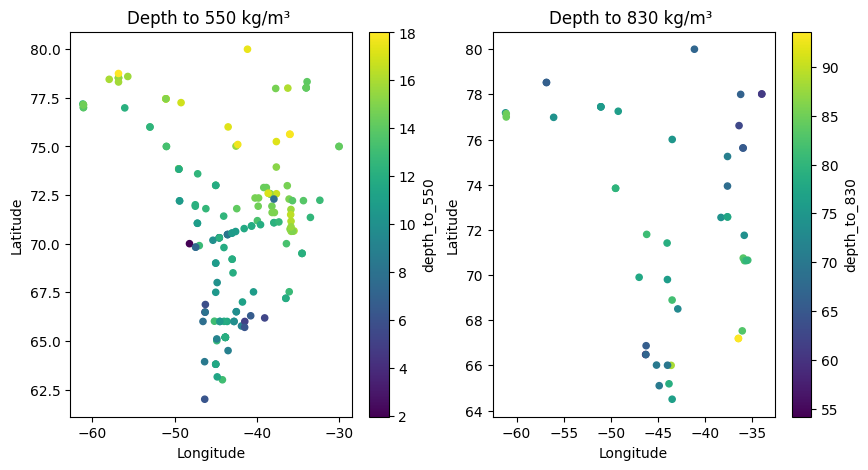

In [32]:
# plot cores

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10, 5))
merged_df.plot.scatter(x='longitude', y='latitude', c='depth_to_550', title='Depth to 550 kg/m³ ', xlabel='Longitude', ylabel='Latitude', ax=ax[0])
merged_df.plot.scatter(x='longitude', y='latitude', c='depth_to_830', title='Depth to 830 kg/m³ ', xlabel='Longitude', ylabel='Latitude', ax=ax[1])

In [36]:
# put it together
merged_df, sumup_df, std_df =merge_datasets(do_run_sumup_processing=False, do_run_std_processing=False, drop_duplicates=True)

Loading sumup data from file... ../data/sumup/processed/sumup_550_830_density_depths_greenland.csv

Loading SUMUP dataset from ../data/sumup/processed/sumup_550_830_density_depths_greenland.csv
Loaded 116 SUMUP records
SUMUP columns: ['core_name', 'profile_key', 'date', 'region', 'latitude', 'longitude', 'elevation', 'citation', 'depth_to_550', 'depth_to_830', 'failed_fit_550', 'failed_fit_830', 'r2_550', 'r2_830', 'year', 'source', 'source_doi']
Loading sumup data from file... ../data/PKM/processed/PKM_550_830_density_depths_greenland.csv

Loading standardized dataset from ../data/PKM/processed/PKM_550_830_density_depths_greenland.csv
Loaded 48 standardized records
Standardized columns: ['core_name', 'latitude', 'longitude', 'elevation', 'year', 'depth_to_550', 'depth_to_830', 'r2_550', 'r2_830', 'failed_fit_550', 'failed_fit_830', 'source', 'method', 'citation', 'measurement_count', 'source_file', 'region']

Creating final dataset...
Removed 3 cores missing depth_to_550
Final dataset

In [39]:
merged_df

,core_name,latitude,longitude,elevation,year,depth_to_550,depth_to_830,r2_550,r2_830,failed_fit_550,failed_fit_830,source,citation,region
0,Eismitte,71.183,-39.933,3000.0,1954,13.40,NaN,0.92,NaN,0,1,SUMUP 2024,Bader (1954) as in Spencer et al. (2001),greenland
1,T15 1959,70.303,-44.570,2491.0,1959,10.97,NaN,0.89,NaN,0,1,SUMUP 2024,Renaud et al. (1959),greenland
2,T31_1959,70.909,-40.640,3008.0,1959,11.90,NaN,0.98,NaN,0,1,SUMUP 2024,Renaud et al. (1959),greenland
3,T43_1959,71.117,-37.317,3174.0,1959,12.69,NaN,0.95,NaN,0,1,SUMUP 2024,Renaud et al. (1959),greenland
4,T53_1959,71.350,-33.483,2867.0,1959,12.54,NaN,0.96,NaN,0,1,SUMUP 2024,Renaud et al. (1959),greenland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,NaN,72.999,-44.997,NaN,2017,11.75,NaN,0.97,NaN,0,1,SUMUP 2024,Lewis et al. (2019),greenland
142,NaN,73.831,-49.478,NaN,2017,11.86,NaN,0.91,NaN,0,1,SUMUP 2024,Lewis et al. (2019),greenland
143,NaN,73.593,-47.197,NaN,2017,12.45,NaN,0.93,NaN,0,1,SUMUP 2024,Lewis et al. (2019),greenland
144,SE-Dome II (X-ray),67.190,-36.470,3160.0,2021,10.70,92.18,0.90,0.96,0,0,SUMUP 2024,Kawakami et al. (2023),greenland


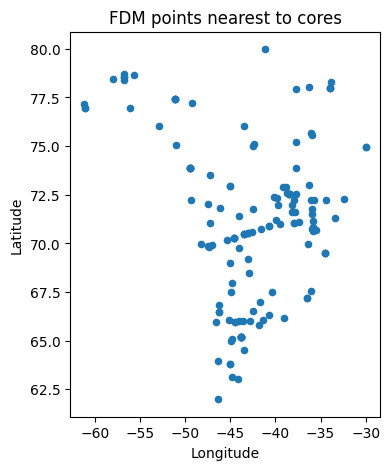

In [ ]:
# extracts FDM points nearest to cores

save_pointlist = True

# import fdm reference list
path_to_fdm_locations = "/perm/nld4814/code/IMAU-FDM/reference/FGRN055/"
pointlist_df = pd.read_csv(path_to_fdm_locations+'IN_ll_FGRN055.txt',names=["longitude","latitude"],usecols=[0,1])

core_locations = merged_df[['latitude','longitude']].to_numpy()

df = pointlist_df

xs = []; distances = []  # distance between the pair of points
for point in core_locations:

    assert len(point) == 2, "``points`` should be a tuple or list of tuples (lat, lon)"

    p_lat, p_lon = point
    # Find absolute difference between requested point and the grid coordinates.
    abslat = np.abs(df.latitude - p_lat)
    abslon = np.abs(df.longitude - p_lon)

    # Create grid of the maximum values of the two absolute grids
    c = np.maximum(abslon, abslat)

    # Find location where lat/lon minimum absolute value intersects
    x = np.where(c == np.min(c))[0][0]
    xs.append(x)

    # Matched Grid lat/lon
    g_lat = df.iloc[x,:].latitude
    g_lon = df.iloc[x,:].longitude

    R = 6373.0  # approximate radius of earth in km

    lat1 = np.deg2rad(p_lat); lon1 = np.deg2rad(p_lon)
    lat2 = np.deg2rad(g_lat); lon2 = np.deg2rad(g_lon)
    dlon = lon2 - lon1; dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    distances.append(distance)

pointlist_df.loc[xs].plot.scatter(x='longitude', y='latitude', title='FDM points nearest to cores', xlabel='Longitude', ylabel='Latitude',figsize=(4,5))

if save_pointlist:
    output_path = "/home/nld4814/perm/cores/pointlist_from_cores_2025.csv"
    pointlist_near_cores = pointlist_df.loc[xs].index.values
    np.savetxt(output_path, pointlist_near_cores, fmt='%d')